In [1]:
# Modeling
import tensorflow as tf
# from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
# from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

from tensorflow.keras.models import Model # , Sequential
from tensorflow.keras.layers import Dense, Attention, GRU, Input
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping # , LearningRateScheduler

from math import sqrt
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from datetime import date, timedelta
import psutil
import os

# Get the current process ID of the IPython kernel
pid = os.getpid()
# Get the process associated with the IPython kernel
process = psutil.Process(pid)

from cylib.apis.all_api import *
from tqdm import tqdm  # For status process bar
from IPython.display import clear_output
import baostock as bs
import pickle

# Suppress the warning
warnings.filterwarnings(
    "ignore", 
    category=pd.core.common.SettingWithCopyWarning)

zscore = StandardScaler()

# Suppress the warning
# warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
Main_bactest = False
Online = False
path_Main = "/home/huh/"
path_HS300_Rolling = "/home/huh/Stage-2/HS300-Rolling/"
path_HS300_Rolling_pic = "/home/huh/Stage-2/HS300-Rolling/Loss-pic/"

begin_date = "20180101"
end_date = "20240430"
today_date = str(date.today())
if Main_bactest:
    end_date = today_date

2024-05-11 18:13:32.077774: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-11 18:13:32.254416: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-11 18:13:32.268655: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-11 18:13:37.410864: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Get the memory usage of the IPython kernel in MB
ram_usage = process.memory_info().rss / (1024 * 1024)
print(f"RAM Usage: {ram_usage} MB")

RAM Usage: 528.23828125 MB


### Get Stocks Data

### Rolling training

In [3]:
'''
price = None
date_all = None
date_train = None
date_last = None
date_backtest = None
date_test = None
date_GRU = None
index = None

price_X_train = None
price_y_train = None
price_X_test = None
price_y_test = None
price_X_drop = None
price_y_drop = None
price_X_backtest = None
history_MLP= None
model_MLP = None
y_pred_MLP_backtest = None
y_pred_MLP_all = None
bst = None
y_pred_GBDT_backtest = None
y_pred_GBDT_all = None
train_X = None
train_y = None
text_X = None
text_y = None
drop_X = None
drop_y = None
history_AGRU = None
model_AGRU = None
y_pred_AGRU_train = None
y_pred_AGRU_test = None
y_pred_AGRU_backtest = None
y_pred_AGRU_all = None

factor_df = None
factor_all = None
factor_df_backtest = None
ICIR = None
'''

class HS_300_Rolling():
    def __init__(self, Price, Price_Return, Path, Date_All, 
                 Date_Backtest, Stocks_code, Backtest_Date_Index) -> None:
        self.RAM_USAGE()
        self.price = Price.loc[Price["trade_date"].isin(Date_All), :]
        self.price_return = Price_Return.loc[Price_Return.index.isin(Date_All), :]
        self.path = Path
        self.backtest_date_index = Backtest_Date_Index
        self.batch_size = len(Stocks_code)
        self.Date_Spliting(Date_All, Date_Backtest)
        self.Data_Spliting()
        self.MLP()
        self.GBDT()
        self.create_sequences()
        self.AGRU()
        self.Create_factor_df()
        self.Ensemble_ICIR_weight()
        self.Ensemble_ICIR_max(self.MLP_ICIR,
                               self.GBDT_ICIR,
                               self.AGRU_ICIR,
                               type_list=["MLP", "GBDT", "AGRU"])
    def RAM_USAGE(self):
        # Get the memory usage of the IPython kernel in MB
        ram_usage = process.memory_info().rss / (1024 * 1024)
        print(f"RAM Usage: {ram_usage} MB")
    def Date_Spliting(self, Date_All, Date_Backtest):
        self.date_all = Date_All
        self.date_backtest = Date_Backtest
        self.date_backtest_Monday = [Date_Backtest[0]]
        self.date_last = [Date_All[-1]] # The last day of all, deciding the next stage's position.
        # Attention: len(date_all) >= 60
        self.date_train, date_test = train_test_split(Date_All, 
                                                      test_size=0.2, 
                                                      shuffle=False)
        self.date_test = date_test[:-11] # If len(date_test[:-11]) == 1, it will be error.
        self.date_drop = date_test[-11:]
        self.date_GRU = Date_All[29:]
    def Data_Spliting(self):
        print("*" * 60)
        print("Data spliting...")
        price = self.price
        # date_train, date_test = train_test_split(trade_date, test_size=0.2, shuffle=False)
        price_train = price.loc[price["trade_date"].isin(self.date_train), :]
        # date_stock = ["trade_date", "ts_code"]
        X_indexes = [
            "OPEN_processed",
            "HIGH_processed",
            "LOW_processed",
            "CLOSE_processed",
            "VWAP_processed",
            "VOLUME_processed",
        ]
        y_index = "Label_processed"
        self.price_X_train = price_train[X_indexes].values
        self.price_y_train = price_train[y_index].values

        price_test = price.loc[price["trade_date"].isin(self.date_test), :]
        price_X_test = price_test[X_indexes].values
        self.price_X_test = price_X_test
        self.price_y_test = price_test[y_index].values

        price_drop = price.loc[price["trade_date"].isin(self.date_drop), :]
        self.price_X_drop = price_drop[X_indexes].values
        # print(list(self.date_backtest))
        price_last = price.loc[price["trade_date"].isin(self.date_last), :]
        self.price_X_last = price_last[X_indexes].values

        self.price_X_all = price[X_indexes].values
        self.price_y_all = price[y_index].values

        self.RAM_USAGE()
        print("*" * 60)

        # del price_train
        # del price_test
        # del price_drop
    def MLP(self):
        print("*" * 60)
        print("MLP training...")
        # Define the MLP model
        model_MLP = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(128, activation="relu"),
                tf.keras.layers.Dropout(0.05),
                tf.keras.layers.Dense(128, activation="relu"),
                tf.keras.layers.Dropout(0.05),
                tf.keras.layers.Dense(128, activation="relu"),
                tf.keras.layers.Dropout(0.05),
                tf.keras.layers.Dense(1),
            ]
        )

        # Compile the model
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        model_MLP.compile(optimizer=optimizer, loss="mean_squared_error")

        # Train the model
        early_stopping_MLP = tf.keras.callbacks.EarlyStopping(
            monitor="loss", patience=50, restore_best_weights=True)
        history_MLP = model_MLP.fit(
            self.price_X_train,
            self.price_y_train,
            epochs=1000,
            callbacks=[early_stopping_MLP],
            validation_data=(self.price_X_test, self.price_y_test),
            batch_size=len(self.price_X_train),  # Set batch size as the training set size
        )

        # Evaluate the model
        self.y_pred_MLP_last = model_MLP.predict(self.price_X_last)
        self.y_pred_MLP_all = model_MLP.predict(self.price_X_all)
        mse_MLP_train = mean_squared_error(self.price_y_train, model_MLP.predict(self.price_X_train))
        mse_MLP_test = mean_squared_error(self.price_y_test, model_MLP.predict(self.price_X_test))

        print(f"MLP MSE(train): {mse_MLP_train}")
        print(f"MLP MSE(test): {mse_MLP_test}")
        # MLP MSE(train): 0.9924953226659671
        # MLP MSE(test): 0.9949950036401641

        def Draw_Loss():
            # Extract loss values from the history object
            training_loss_MLP = history_MLP.history['loss']
            validation_loss_MLP = history_MLP.history['val_loss']

            # Create a range of epochs for x-axis
            epochs = range(1, len(training_loss_MLP) + 1)

            # Plot the training and validation loss values
            plt.figure()
            plt.plot(epochs, training_loss_MLP, label='Training Loss')
            plt.plot(epochs, validation_loss_MLP, label='Validation Loss')
            plt.title('Training and Validation Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.savefig(path_HS300_Rolling_pic + f'MLP_{self.backtest_date_index}.png')
            # plt.show()
        Draw_Loss()
        # self.history_MLP = history_MLP
        print("*" * 60)
    def GBDT(self):
        print("*" * 60)
        print("GBDT training...")
        params = {
            "learning_rate": 0.01,
            "max_depth": 64,
            "max_leaves": 512,
            "min_child_weight": 512,
            "subsample": 0.7,
            "colsample_bytree": 0.7,
            "objective": "reg:squarederror",
        }

        dtrain = xgb.DMatrix(self.price_X_train, label=self.price_y_train)
        dtest = xgb.DMatrix(self.price_X_test, label=self.price_y_test)
        dlast = xgb.DMatrix(self.price_X_last)
        dall = xgb.DMatrix(self.price_X_all)

        evals = [(dtest, "eval"), (dtrain, "train")]
        num_round = 200

        bst = xgb.train(
            params, 
            dtrain, 
            num_round, 
            evals, 
            early_stopping_rounds=50, 
            verbose_eval=True
        )

        self.y_pred_GBDT_last = bst.predict(dlast)
        self.y_pred_GBDT_all = bst.predict(dall)
        mse_GBDT_train = mean_squared_error(self.price_y_train, bst.predict(dtrain))
        mse_GBDT_test = mean_squared_error(self.price_y_test, bst.predict(dtest))

        print(f"GBDT MSE(train): {mse_GBDT_train}")
        print(f"GBDT MSE(test): {mse_GBDT_test}")
        # GBDT MSE(train): 0.9476405621114625
        # GBDT MSE(test): 1.002617615102808

        # train_rmse = []
        # eval_rmse = []
        # def Draw_Loss():
        #     plt.plot(train_rmse, label='Training RMSE')
        #     plt.plot(eval_rmse, label='Validation RMSE')
        #     plt.xlabel('epochs')
        #     plt.ylabel('RMSE')
        #     plt.title('Training and Validation RMSE')
        #     plt.legend()
        #     plt.show()
        self.RAM_USAGE()
        self.bst = bst
        print("*" * 60)
    def create_sequences(self, Sequence_length=30):
        print("*" * 60)
        print("Creating sequences...")
        # Create sequences of variable length for each stock
        """
        sequence length: number of time steps in the entire sequence.
        In this paper, sequence length = 30.

        type: 'train' or 'test'

        begin index: index of the first sequence
        end index: index of the last sequence
        """
        def Sequences(df, sequence_length, begin_index, end_index):
            sequences = []
            labels = []
            for stock in df["ts_code"].unique():
                # Single stock dataframe
                stock_df = df[df["ts_code"] == stock].reset_index(drop=True)
                for i in range(sequence_length + begin_index, end_index + 2):
                    # The last sequence is included.
                    seq = stock_df.iloc[i - sequence_length : i][
                        [
                            "OPEN_processed",
                            "HIGH_processed",
                            "LOW_processed",
                            "CLOSE_processed",
                            "VWAP_processed",
                            "VOLUME_processed",
                        ]
                    ].values
                    label = stock_df.iloc[i - 1]["Label_processed"]
                    sequences.append(seq)
                    labels.append(label)
            return np.array(sequences), np.array(labels)
        # Set the desired sequence length
        sequence_length = Sequence_length
        train_X, train_y = Sequences(
            self.price, 
            sequence_length, 
            0, 
            len(self.date_train) - 1
        )
        # Note: len(date_train) + len(date_test) is the length of Modeling date.
        test_X, test_y = Sequences(
            self.price,
            sequence_length,
            len(self.date_train) - sequence_length + 1,
            len(self.date_train) + len(self.date_test) - 1,
        )
        drop_X, _ = Sequences(
            self.price,
            sequence_length,
            len(self.date_train) + len(self.date_test) - sequence_length + 1,
            len(self.date_all) - 1,
        )
        last_X, _ = Sequences(
            self.price,
            sequence_length,
            len(self.date_all) - sequence_length,
            len(self.date_all) - 1,
        )
        self.train_X = train_X
        self.train_y = train_y
        self.test_X = test_X
        self.test_y = test_y
        self.drop_X = drop_X
        self.last_X = last_X
        # self.last_y = last_y
        print("train_X:", train_X.shape)
        print("test_X:", test_X.shape)
        print("drop_X:", drop_X.shape)
        print("last_X:", last_X.shape)
        print("*" * 60)
    def AGRU(self):
        print("*" * 60)
        print("AGRU training...")
        # Define the AGRU model
        inputs = Input(shape=(30, 6))
        gru = GRU(units=6, return_sequences=True)(inputs)
        att = Attention()([gru, gru])
        gru = GRU(units=6)(att)
        outputs = Dense(1)(gru)

        model_AGRU = Model(inputs=inputs, outputs=outputs)

        # Compile the model
        model_AGRU.compile(optimizer=Adam(learning_rate=1e-3), 
                           loss="mean_squared_error")

        # Define early stopping criteria
        early_stopping_AGRU = EarlyStopping(monitor="loss", 
                                            patience=20, 
                                            restore_best_weights=True)

        # Train the model
        history_AGRU = model_AGRU.fit(
            self.train_X,
            self.train_y,
            epochs=200,
            batch_size=self.batch_size,
            validation_data=(self.test_X, self.test_y),
            callbacks=[early_stopping_AGRU],
        )

        # Evaluate the model
        loss = model_AGRU.evaluate(self.test_X, self.test_y)
        print("Model trained with loss:", loss)
        # Evaluate the model on test data
        y_pred_AGRU_train = model_AGRU.predict(self.train_X)
        self.y_pred_AGRU_train = y_pred_AGRU_train
        y_pred_AGRU_test = model_AGRU.predict(self.test_X)
        self.y_pred_AGRU_test = y_pred_AGRU_test
        y_pred_AGRU_drop = model_AGRU.predict(self.drop_X)
        self.y_pred_AGRU_last = model_AGRU.predict(self.last_X)
        # y_pred_AGRU_backtest = np.concatenate(
        #     (y_pred_AGRU_test.reshape(-1), 
        #      y_pred_AGRU_drop.reshape(-1))
        # )
        # self.y_pred_AGRU_backtest = y_pred_AGRU_backtest
        self.y_pred_AGRU_all = np.concatenate((np.concatenate((y_pred_AGRU_train.reshape(-1), 
                                                               y_pred_AGRU_test.reshape(-1))),
                                                               y_pred_AGRU_drop.reshape(-1)))
        mse_AGRU_train = mean_squared_error(self.train_y, y_pred_AGRU_train)
        mse_AGRU_test = mean_squared_error(self.test_y, y_pred_AGRU_test)
        print(f"AGRU MSE(train): {mse_AGRU_train}")
        print(f"AGRU MSE(test): {mse_AGRU_test}")
        # AGRU MSE(train): 0.9896615693578518
        # AGRU MSE(test): 0.9960141348406323

        def Draw_Loss():
            # Extract loss values from the history object
            training_loss_AGRU = history_AGRU.history['loss']
            validation_loss_AGRU = history_AGRU.history['val_loss']

            # Create a range of epochs for x-axis
            epochs = range(1, len(training_loss_AGRU) + 1)

            # Plot the training and validation loss values
            plt.figure()
            plt.plot(epochs, training_loss_AGRU, label='Training Loss')
            plt.plot(epochs, validation_loss_AGRU, label='Validation Loss')
            plt.title('Training and Validation Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.savefig(path_HS300_Rolling_pic + f'AGRU_{self.backtest_date_index}.png')
            # plt.show()
        Draw_Loss()
        print("*" * 60)
    def Create_factor_df(self):
        print("*" * 60)
        print("Creating factor df...")
        price = self.price
        price_return = self.price_return
        def Create_Factor_all(y_pred_all):
            # This is for y_pred_all.
            factor_df = price[["trade_date", "ts_code"]]  # Date and stock
            factor_df.loc[:, "Factor_values"] = y_pred_all  # Add factor values
            factor_df = factor_df.pivot(
                index="trade_date", columns="ts_code", values="Factor_values"
            )  # Transfer to factor dataframe
            return factor_df

        def Create_Factor_backtest(y_pred_backtest):
            # This is for y_pred_all.
            factor_df = price.loc[price["trade_date"].isin(self.date_last), :][
                ["trade_date", "ts_code"]]  # Date and stock
            factor_df.loc[:, "Factor_values"] = y_pred_backtest  # Add factor values
            factor_df = factor_df.pivot(
                index="trade_date", columns="ts_code", values="Factor_values"
            )  # Transfer to factor dataframe
            return factor_df

        def Create_ICIR_df(factor_DF):
            # This is for y_pred_all.
            IC_series = factor_DF.corrwith(price_return, axis=1, method="spearman")
            ICIR_df = IC_series.shift(1).rolling(60).apply(lambda x: x.mean() / x.std())
            ICIR_df = ICIR_df[
                ICIR_df.index.isin(self.date_last)
            ]  # Select the ICIR in the test date.
            return ICIR_df

        MLP_factor_all = Create_Factor_all(self.y_pred_MLP_all)
        self.MLP_factor_backtest = Create_Factor_backtest(self.y_pred_MLP_last)
        GBDT_factor_all = Create_Factor_all(self.y_pred_GBDT_all)
        self.GBDT_factor_backtest = Create_Factor_backtest(self.y_pred_GBDT_last)

        AGRU_factor_all = price.loc[price["trade_date"].isin(self.date_GRU), :].reset_index(
            drop=True)
        AGRU_factor_all = AGRU_factor_all[["trade_date", "ts_code"]]  # Date and stock
        AGRU_factor_all.loc[:, "AGRU"] = self.y_pred_AGRU_all  # Add factor values
        AGRU_factor_all = AGRU_factor_all.pivot(
            index="trade_date", columns="ts_code", values="AGRU"
        )  # Transfer to factor dataframe
        self.AGRU_factor_backtest = Create_Factor_backtest(self.y_pred_AGRU_last)

        # Use abs()
        MLP_ICIR = Create_ICIR_df(MLP_factor_all)
        self.MLP_ICIR = MLP_ICIR.abs()
        GBDT_ICIR = Create_ICIR_df(GBDT_factor_all)
        self.GBDT_ICIR = GBDT_ICIR.abs()
        AGRU_ICIR = Create_ICIR_df(AGRU_factor_all)
        self.AGRU_ICIR = AGRU_ICIR.abs()
        print("*" * 60)
    def Ensemble_ICIR_weight(self):
        # Ensemble the models based on ICIR weight
        SUM_ICIR = self.MLP_ICIR + self.GBDT_ICIR + self.AGRU_ICIR
        MLP_ratio = self.MLP_ICIR / SUM_ICIR
        GBDT_ratio = self.GBDT_ICIR / SUM_ICIR
        AGRU_ratio = self.AGRU_ICIR / SUM_ICIR

        MLP_weight = self.MLP_factor_backtest.multiply(MLP_ratio, axis=0)
        GBDT_weight = self.GBDT_factor_backtest.multiply(GBDT_ratio, axis=0)
        AGRU_weight = self.AGRU_factor_backtest.multiply(AGRU_ratio, axis=0)

        Ensemble_weight_factor_df = MLP_weight + GBDT_weight + AGRU_weight
        Ensemble_weight_factor_df_Monday = Ensemble_weight_factor_df.copy()
        Ensemble_weight_factor_df_Monday.index = self.date_backtest_Monday
        Ensemble_weight_factor_df_Monday = Ensemble_weight_factor_df_Monday.rename_axis(index='trade_date')
        Ensemble_weight_factor_df_Monday.to_csv(self.path + 
                                                f'Ensemble_weight_factor_df_Monday_{self.backtest_date_index}.csv')
        self.Ensemble_weight_factor_df_Monday = Ensemble_weight_factor_df_Monday
    def Ensemble_ICIR_max(self, *ICIR_df, type_list):
        # Ensemble the models based on max ICIR
        # Use: Ensemble_ICIR_max(MLP_ICIR, GBDT_ICIR, AGRU_ICIR,
        #                        type_list=["MLP", "GBDT", "AGRU"])

        # Concatenate ICIR DataFrames into Combine_df
        # for ICIR in ICIR_df:
        #     Combine_df = pd.concat([Combine_df, ICIR], axis=1)
        Combine_df = pd.concat(ICIR_df, axis=1)
        Combine_df.columns = type_list
        # print(Combine_df)
        Combine_ranks = Combine_df.rank(axis=1, ascending=False)

        # Choose max ICIR and assign it as 1, others as 0
        Keep_df = Combine_ranks.applymap(lambda x: 1 if x == 1 else 0)

        Ensemble_max = pd.DataFrame()
        for TYPE in type_list:
            # Dynamically create variable names using exec()
            keepp = Keep_df[TYPE]
            # Find factor df use getattr()
            factor_df = getattr(self, f'{TYPE}_factor_backtest')
            positionn = factor_df.where(keepp == 1, 0)
            Ensemble_max = Ensemble_max.add(positionn, fill_value=0)
        Ensemble_max_factor_df = Ensemble_max
        Ensemble_max_factor_df_Monday = Ensemble_max_factor_df.copy()
        Ensemble_max_factor_df_Monday.index = self.date_backtest_Monday
        Ensemble_max_factor_df_Monday = Ensemble_max_factor_df_Monday.rename_axis(index='trade_date')
        Ensemble_max_factor_df_Monday.to_csv(self.path + 
                                             f'Ensemble_max_factor_df_Monday_{self.backtest_date_index}.csv')
        self.Ensemble_max_factor_df_Monday = Ensemble_max_factor_df_Monday

In [4]:
if not Online:
    date_all = pd.read_csv(path_HS300_Rolling + 'date_all.csv', 
                           index_col=0, 
                           parse_dates=True).index
    date_train, date_backtest = train_test_split(date_all, test_size=0.2, shuffle=False)

    # Load the stocks code from the file
    with open(path_HS300_Rolling + 'stocks_code.pkl', 'rb') as file:
        stocks_code = pickle.load(file)

    price = pd.read_csv(path_HS300_Rolling + "price_processed.csv", 
                        parse_dates=["trade_date"])
    price_return = pd.read_csv(path_HS300_Rolling + "price_return.csv", 
                        parse_dates=["trade_date"],
                        index_col="trade_date")
    # benchmark = pd.read_csv(path_HS300_Rolling + "benchmark.csv", 
    #                         parse_dates=["trade_date"])

In [5]:
# Create a DataFrame with the DatetimeIndex
date_all_df = pd.DataFrame(index=date_all)
date_backtest_df = pd.DataFrame(index=date_backtest)
date_all_df["Monday"] = (date_all_df.index.dayofweek == 0).astype(int)  # Add Monday
date_backtest_df["Monday"] = (date_backtest_df.index.dayofweek == 0).astype(int)  # Add Monday
date_backtest_Monday_df = date_backtest_df[date_backtest_df["Monday"] == 1]

# Check if the first backtest day is Monday
First_Monday = bool(date_backtest_df.values[0])
rolling_length = len(date_backtest_Monday_df)

In [6]:
rolling_length

62

In [7]:
def test():
    # Rolling training, the whole training step is not included in it.
    begin_index = -1
    end_index = rolling_length - 1
    for i in range(begin_index, end_index + 1):
        if i == -1 and not First_Monday:
            # The first backtest is the interval from the beginning to the first Monday.
            # Because the first day is not Monday, for corresponding date_backtest demand consideration,
            # we make the first day of date_backtest as a first backtest day in the first rolling step.
            backtest_begin = date_backtest_df.index[0]
            Next_backtest_begin = date_backtest_Monday_df.index[0]
        elif i == -1 and First_Monday: continue
        else:
            backtest_begin = date_backtest_Monday_df.index[i]
            if i < rolling_length - 1:
                Next_backtest_begin = date_backtest_Monday_df.index[i + 1]
            # If it is the last week.
            else: Next_backtest_begin = date_backtest_Monday_df.index[-1] + timedelta(weeks=1)
        date_all_rolling = date_all_df[date_all_df.index < backtest_begin].index
        date_backtest_rolling = date_all_df[(date_all_df.index >= backtest_begin) & 
                                            (date_all_df.index < Next_backtest_begin)].index
        # print(date_all_rolling)
        print(date_backtest_rolling)
test()

DatetimeIndex(['2023-01-20'], dtype='datetime64[ns]', name='trade_date', freq=None)
DatetimeIndex(['2023-01-30', '2023-01-31', '2023-02-01', '2023-02-02',
               '2023-02-03'],
              dtype='datetime64[ns]', name='trade_date', freq=None)
DatetimeIndex(['2023-02-06', '2023-02-07', '2023-02-08', '2023-02-09',
               '2023-02-10'],
              dtype='datetime64[ns]', name='trade_date', freq=None)
DatetimeIndex(['2023-02-13', '2023-02-14', '2023-02-15', '2023-02-16',
               '2023-02-17'],
              dtype='datetime64[ns]', name='trade_date', freq=None)
DatetimeIndex(['2023-02-20', '2023-02-21', '2023-02-22', '2023-02-23',
               '2023-02-24'],
              dtype='datetime64[ns]', name='trade_date', freq=None)
DatetimeIndex(['2023-02-27', '2023-02-28', '2023-03-01', '2023-03-02',
               '2023-03-03'],
              dtype='datetime64[ns]', name='trade_date', freq=None)
DatetimeIndex(['2023-03-06', '2023-03-07', '2023-03-08', '2023-03-09',


In [8]:
# # Rolling training, the whole training step is not included in it.
# Index = 0

# if Index == -1 and not First_Monday:
#     # The first backtest is the interval from the beginning to the first Monday.
#     # Because the first day is not Monday, for corresponding date_backtest demand consideration,
#     # we make the first day of date_backtest as a first backtest day in the first rolling step.
#     backtest_begin = date_backtest_df.index[0]
#     Next_backtest_begin = date_backtest_Monday_df.index[0]
# elif Index == -1 and First_Monday: pass
# else:
#     backtest_begin = date_backtest_Monday_df.index[Index]
#     if Index < rolling_length - 1:
#         Next_backtest_begin = date_backtest_Monday_df.index[Index + 1]
#     # If it is the last week.
#     else: Next_backtest_begin = date_backtest_Monday_df.index[-1] + timedelta(weeks=1)
# print("*" * 60)
# print(f"This is the {Index} th rolling step.")
# print("*" * 60)
# date_all_rolling = date_all_df[date_all_df.index < backtest_begin].index
# date_backtest_rolling = date_all_df[(date_all_df.index >= backtest_begin) & 
#                                     (date_all_df.index < Next_backtest_begin)].index
# HS300_ROLLING = HS_300_Rolling(Price=price, 
#                                Price_Return=price_return,
#                                Path=path_HS300_Rolling,
#                                Date_All=date_all_rolling, 
#                                Date_Backtest=date_backtest_rolling, 
#                                Stocks_code=stocks_code,
#                                Backtest_Date_Index=Index)
# # print(date_all_rolling)
# # print(date_backtest_rolling)

Rolling Progress: 100%|███████████████████████████████████████████| 1/1 [2:16:19<00:00, 8179.94s/it]


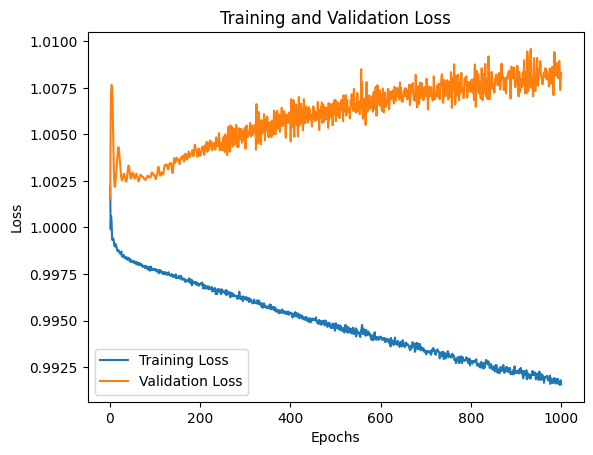

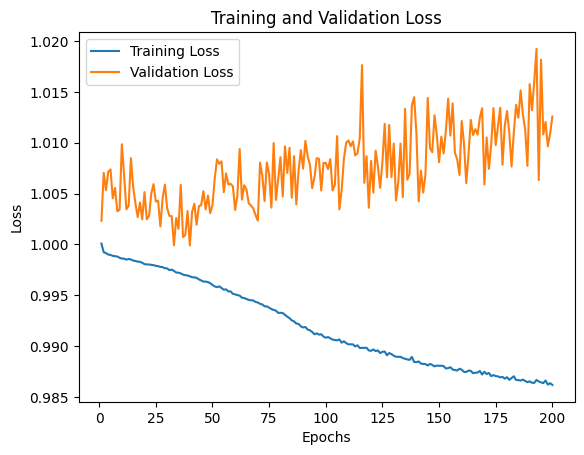

In [9]:
# Rolling training, the whole training step is not included in it.
begin_index = 61
end_index = 61
true_step = 0
for i in tqdm(range(begin_index, end_index + 1), desc="Rolling Progress", ncols=100):
    if i == -1 and not First_Monday:
        # The first backtest is the interval from the beginning to the first Monday.
        # Because the first day is not Monday, for corresponding date_backtest demand consideration,
        # we make the first day of date_backtest as a first backtest day in the first rolling step.
        backtest_begin = date_backtest_df.index[0]
        Next_backtest_begin = date_backtest_Monday_df.index[0]
    elif i == -1 and First_Monday: continue
    else:
        backtest_begin = date_backtest_Monday_df.index[i]
        if i < rolling_length - 1:
            Next_backtest_begin = date_backtest_Monday_df.index[i + 1]
        # If it is the last week.
        else: Next_backtest_begin = date_backtest_Monday_df.index[-1] + timedelta(weeks=1)
    true_step += 1
    print("*" * 60)
    print(f"This is the {i} th rolling step. Finished {round(i/(rolling_length - 1)*100, 2)}% of all.")
    print("*" * 60)
    date_all_rolling = date_all_df[date_all_df.index < backtest_begin].index
    date_backtest_rolling = date_all_df[(date_all_df.index >= backtest_begin) & 
                                        (date_all_df.index < Next_backtest_begin)].index
    HS300_ROLLING = HS_300_Rolling(Price=price, 
                                   Price_Return=price_return,
                                   Path=path_HS300_Rolling,
                                   Date_All=date_all_rolling, 
                                   Date_Backtest=date_backtest_rolling, 
                                   Stocks_code=stocks_code,
                                   Backtest_Date_Index=i)
    # Clear the output of the current cell
    clear_output(wait=True)
    # print(date_all_rolling)
    # print(date_backtest_rolling)

In [10]:
class Backtest():
    def __init__(self) -> None:
        self.all_stocks = get_targets_info(target_type="stock")
    def Ensure_position(self, DF):
        # We add a column named 'Monday' and change positions every Monday.
        DF = DF.shift(1)  # Move one step forward to ensure position
        DF["Monday"] = (DF.index.dayofweek == 0).astype(int)  # Shift except Monday

        # Get the columns to shift (all columns except 'Monday')
        cols_to_shift = DF.columns[DF.columns != "Monday"]

        DF.loc[DF["Monday"] == 0, cols_to_shift] = np.nan
        DF.fillna(
            method="ffill", inplace=True
        )  # Forward fill, holing positions for a week.
        DF.fillna(value=0, inplace=True)  # Fill remaining NaN with 0
        return DF
    def Backtest_Layer(self, factor_df, TYPE, num_layers = 20):
        # Calculte the ranks of factors daily.
        factor_ranks = factor_df.rank(axis=1, ascending=False)

        # The factor ordering is divided into num_layers, each of which allocates funds equally.
        layer_allocation = (factor_ranks // (len(factor_df.columns) / num_layers)).fillna(0)

        # import matplotlib.cm as cm

        plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号
        plt.figure(figsize=(10, 5))
        plt.axhline(y=1, color="grey", linestyle="--")

        # Define a color map to use for changing colors progressively
        # colors = plt.cm.jet(np.linspace(0, 1, num_layers))

        # global profit_long, profit_short
        profit_long = profit_short = None

        def Long_Short(Num_layers, Layer, Profit):
            global profit_long, profit_short
            long_layer = Num_layers - 1
            short_layer = 0
            if Layer == short_layer:
                profit_short = Profit
                # The short profit comes from the decline of the stock.
                profit_short = profit_short.apply(
                    lambda x: x + 1 if x == 0 else -x + (1 - 0.0003))
                profit_short = profit_short.cumprod()
                profit_short *= 0.5
            elif Layer == long_layer:
                profit_long = Profit
                profit_long = profit_long.apply(
                    lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
                profit_long = profit_long.cumprod()
                profit_long *= 0.5

        Long_position_df = None
        for layer in range(0, num_layers):
            # Ensure holding stocks
            hold_flag_matrix = layer_allocation.mask(layer_allocation != layer, 0).mask(
                layer_allocation == layer, 1)
            hold_flag_matrix = self.Ensure_position(hold_flag_matrix)
            if layer == num_layers - 1:
                Long_position_df = hold_flag_matrix.copy()

            # Delete 'Monday' to fit into yield dataframe.
            del hold_flag_matrix["Monday"]

            # Calculate the sum of each line in turn.
            stock_amount_sum = hold_flag_matrix.sum(axis=1)

            # Calculate the weight of each stock. (Average distribution at the same level)
            weight_allocation = hold_flag_matrix.apply(
                lambda x: x / stock_amount_sum, axis=0
            ).fillna(0)
            
            # Calculate the daily profit rate. And prepare to calculate cumprod.
            profit = (weight_allocation * self.price_return_backtest).sum(axis=1)

            # Create Long and Short position
            Long_Short(num_layers, layer, profit)

            # Calculate the daily equity and draw.
            # Using the 'viridis' colormap with a gradient based on layer number
            colors = cm.viridis(layer / num_layers)
            profit = profit.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
            profit.cumprod().plot(label=layer, legend=True, color=colors)

        profit_HS300 = self.HS_300_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
        profit_HS300.cumprod().plot(label="HS 300 index", legend=True, color="r")
        profit_CS500 = self.CS_500_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
        profit_CS500.cumprod().plot(label="CS 500 index", legend=True, color="g")
        profit_CS1000 = self.CS_1000_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
        profit_CS1000.cumprod().plot(label="CS 1000 index", legend=True, color="b")

        (profit_long + profit_short).plot(color="orange", label="long_short", legend=True)
        plt.title(f"20-Layered Portfolio Equity ({type})")
        plt.legend(title="Layer", bbox_to_anchor=(1, 0.5), loc="center left")
        plt.show()

        setattr(self, f'profit_long_{TYPE}', profit_long)
        setattr(self, f'Long_position_df_{TYPE}', Long_position_df)
    def Simple_Backtest(self, factor_df, stock_num, Ascending):
        # Calculte the ranks of factors daily.
        factor_ranks = factor_df.rank(axis=1, ascending=Ascending)

        # Create position_df based on top 3 ranks
        position_df = factor_ranks.apply(lambda x: x <= stock_num).astype(int)
        position_df = self.Ensure_position(position_df)

        # Delete 'Monday' to fit into yield dataframe.
        del position_df["Monday"]

        # Calculate the sum of each line in turn.
        stock_amount_sum = position_df.sum(axis=1)

        # Calculate the weight of each stock. (Average distribution at the same level)
        weight_allocation = position_df.apply(
            lambda x: x / stock_amount_sum, axis=0
        ).fillna(0)

        # Calculate the daily profit rate. And prepare to calculate cumprod.
        profit = (weight_allocation * price_return_backtest).sum(axis=1)

        plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号
        plt.figure(figsize=(10, 5))
        plt.axhline(y=1, color="grey", linestyle="--")
        # Calculate the daily equity and draw.
        profit = profit.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
        profit.cumprod().plot(label="Stocks", legend=True, color="#800080")

        profit_HS300 = self.HS_300_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
        profit_HS300.cumprod().plot(label="HS 300 index", legend=True, color="r")
        profit_CS500 = self.CS_500_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
        profit_CS500.cumprod().plot(label="CS 500 index", legend=True, color="g")
        profit_CS1000 = self.CS_1000_backtest.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
        profit_CS1000.cumprod().plot(label="CS 1000 index", legend=True, color="b")

        plt.title(f"Equity of {stock_num} stocks")
        plt.legend(title="Index", bbox_to_anchor=(1, 0.5), loc="center left")
        plt.show()
    def Ensure_Future_position_all(self, factor_df, layer, num_layers = 20):
        all_stocks = self.all_stocks

        last_day = factor_df.iloc[-1, :]
        # Calculte the ranks of factors daily.
        factor_ranks = last_day.rank(ascending=False)

        # The factor ordering is divided into num_layers, each of which allocates funds equally.
        layer_allocation = (factor_ranks // (len(last_day) / num_layers)).fillna(0)

        selected_stocks_main = list(layer_allocation[layer_allocation == layer].index)
        self.selected_stocks_main = selected_stocks_main
        self.selected_stocks_main_info = all_stocks[all_stocks['ts_code'].isin(selected_stocks_main)]
    def Ensure_Future_position_small(self, factor_df, stock_num, Ascending):
        price = self.price

        last_day = factor_df.iloc[-1, :]

        # Calculte the ranks of factors daily.
        factor_ranks = last_day.rank(ascending=Ascending)

        # Create a boolean mask to identify columns where values are between 0 and stock_num - 1
        mask = (factor_ranks > 0) & (factor_ranks <= stock_num)
        print(factor_ranks[mask].sort_values())
        selected_stocks_simple = list(factor_ranks[mask].sort_values().index)
        self.selected_stocks_simple = selected_stocks_simple
        self.Trade_Stock_Close_Dict_simple = dict(price.pivot(index="trade_date", 
                                                 columns="ts_code", 
                                                 values="CLOSE")[selected_stocks_simple].iloc[-1, :])
        self.selected_stocks_simple_info = all_stocks[all_stocks['ts_code'].isin(selected_stocks_simple)]
    def Real_trading(self, Stock_Price_dict, Money, slippage):
        # Plan A: Buy at open and sell at close
        # Plan B:
        """
        Stamp_duty = 0.0005 (Sell)
        Transfer_fee = 0.00001 (Buy + Sell)
        Commission = 0.00025 (Buy + Sell)(Commission > 5)
        """
        Stock_codes = list(Stock_Price_dict.keys())
        Average_Capital = Money / len(Stock_codes)
        print("Initial Average Capital:", Average_Capital)
        reduce_hand = 0
        position_dict_simple = dict()
        while(1):
            All = 0
            for stock in Stock_codes:
                price = Stock_Price_dict[stock] + slippage
                hands = Average_Capital // (price * 100) - reduce_hand
                Initial = hands * price * 100
                Transfer_fee = Initial * 0.00001
                Commission = Initial * 0.00025 if Initial * 0.00025 >= 5 else 5
                total = Initial + Transfer_fee + Commission
                position_dict_simple[stock] = f"price: {price}, total: {total}, hands: {hands}, fee: {Transfer_fee+Commission}"
                All += Initial + Transfer_fee + Commission
            if All > Money:
                reduce_hand += 1
            else:
                print(f"All init money: {Money}")
                print(f"All position money: {All}")
                break
        self.position_dict_simple = position_dict_simple
    def Backtest_Indexes(self, TYPE):
        print(f'{TYPE} Indexes')
        # ICIR
        price_return_backtest = self.price_return_backtest
        factor_df = getattr(self, f'{TYPE}_factor_df')
        profit_long = getattr(self, f'profit_long_{TYPE}')
        IC_series = factor_df.corrwith(price_return_backtest, 
                                       axis=1, 
                                       method="spearman")
        IC_mean = IC_series.mean()
        print(f"IC mean: {IC_mean}")
        ICIR = IC_series.mean() / IC_series.std()
        print(f"ICIR: {ICIR}")
        IC_series.hist(bins=30)

        # RankIC
        # Create a figure and axis
        _, ax = plt.subplots(figsize=(8, 4))
        # Plot histogram of values on the left side
        ax.bar(IC_series.index, IC_series.values)
        ax.set_title('Histogram of Series Values')
        ax.set_xlabel('Date')
        ax.set_ylabel('RankIC')
        # Create a twin Axes sharing the xaxis
        ax2 = ax.twinx()
        # Plot cumulative line on the right side
        ax2.plot(IC_series.index, IC_series.cumsum(), color='orange')
        ax2.set_ylabel('Cumulative Sum')
        
        # IC winning rate
        IC_winning_rate = sum(1 for ic in IC_series if ic > 0) / len(IC_series)
        print(f"IC winning rate: {IC_winning_rate}")

        t_value = ICIR / sqrt(len(IC_series))
        print(f"IC t-value: {t_value}")

        # Long (Except Short), so `profit_long * 2`
        # profit_long is long equity series.
        Long_equity = profit_long * 2
        Long_ROI = (Long_equity[-1]) - 1
        print(f"Long ROI: {Long_ROI}")

        # Max Drawdown
        # Calculate the previous peaks
        previous_peaks = Long_equity.cummax()
        # Calculate the drawdowns
        drawdowns = (Long_equity - previous_peaks) / previous_peaks

        # Find the maximum drawdown and the dates associated with it
        # Convert the index labels to a numeric format
        drawdowns.index = pd.to_numeric(drawdowns.index)
        max_drawdown = drawdowns.min()
        print(f"Max drawdown: {max_drawdown}")
        max_drawdown_start = drawdowns.idxmin()

        # Convert the start and end dates back to the original format if needed
        max_drawdown_start = pd.to_datetime(max_drawdown_start).date()
        print(f"Max drawdown begin date: {max_drawdown_start}")

        plt.show()

    def Factor_Correlation(self, *Factor_df, type_list):
        # Factor cross-sectional correlation
        for i in range(len(Factor_df) - 1):
            temp_df = Factor_df[i]
            for j in range(i + 1, len(Factor_df)):
                temp_df.corrwith(Factor_df[j], axis=1).plot(label=f'{type_list[i]} & {type_list[j]}',
                                                            legend=True)
        plt.title(f"Correlation of Daily Factor Values")
        plt.legend(title="Factors", bbox_to_anchor=(1, 0.5), loc="center left")
        plt.show()
    def Average_IC_Correlation(self, *Factor_df, type_list):
        # Average Factor cross-sectional correlatcolumnsion
        Average_IC_matrix = pd.DataFrame(index=type_list, columns=type_list)
        np.fill_diagonal(Average_IC_matrix.values, 1) # Assign it with unit matrix
        for i in range(len(Factor_df) - 1):
            temp_df = Factor_df[i]
            for j in range(i + 1, len(Factor_df)):
                corr = temp_df.corrwith(Factor_df[j], axis=1).mean()
                # This is a symmetric matrix.
                Average_IC_matrix.iat[i, j] = corr
                Average_IC_matrix.iat[j, i] = corr
        # Convert data type of Average_IC_matrix to float for heatmap
        Average_IC_matrix = Average_IC_matrix.astype(float)

        # Create a heatmap
        plt.figure(figsize=(8, 6))

        # Create a custom color map with reduced brightness based on 'viridis'
        viridis_cmap = plt.colormaps.get_cmap('viridis')
        new_colors = viridis_cmap(np.linspace(0.2, 1, 256)) ** 0.5  # Adjust the brightness level here
        custom_cmap = sns.color_palette(new_colors)

        sns.heatmap(Average_IC_matrix, annot=True, cmap=custom_cmap, fmt=".4f")
        plt.title('Correlation Heatmap with IC series')
        plt.show()
    def IC_Correlation(self, *factor_df, price_return, type_list):
        # Correlation of factor IC series
        IC_Correlation_df = None
        for factor in factor_df:
            Corr = factor.corrwith(price_return, axis=1)
            IC_Correlation_df = pd.concat([IC_Correlation_df, Corr], axis=1)
        # Change the columns to type_list
        IC_Correlation_df.columns = type_list
        IC_Correlation_matrix = IC_Correlation_df.corr()
        # Create a heatmap
        plt.figure(figsize=(8, 6))

        # Create a custom color map with reduced brightness based on 'viridis'
        viridis_cmap = plt.colormaps.get_cmap('viridis')
        new_colors = viridis_cmap(np.linspace(0.2, 1, 256)) ** 0.5  # Adjust the brightness level here
        custom_cmap = sns.color_palette(new_colors)

        sns.heatmap(IC_Correlation_matrix, annot=True, cmap=custom_cmap, fmt=".4f")
        plt.title('Correlation Heatmap with IC series')
        plt.show()

`getattr()` is a built-in Python function that allows you to retrieve the value of an attribute of an object based on its name. Here's a precise explanation:

- **Syntax**: `getattr(object, name[, default])`
  
  - `object`: The object from which to retrieve the attribute.
  - `name`: A string representing the name of the attribute you want to access.
  - `default` (optional): If the attribute doesn't exist and a default value is provided, this value will be returned instead of raising an AttributeError.

- **Functionality**:
  
  - `getattr()` retrieves the value of the attribute with the specified name from the given object.
  - If the attribute exists, its value is returned.
  - If the attribute doesn't exist and a default value is provided, the default value is returned.
  - If the attribute doesn't exist and no default value is provided, `getattr()` raises an AttributeError.

- **Example**:
  
  ```python
  class MyClass:
      def __init__(self):
          self.x = 10
          self.y = 20
  
  obj = MyClass()
  
  # Accessing attributes using getattr()
  value_x = getattr(obj, 'x')  # Retrieves the value of attribute 'x' (value_x = 10)
  value_y = getattr(obj, 'y')  # Retrieves the value of attribute 'y' (value_y = 20)
  value_z = getattr(obj, 'z', 'default')  # 'z' doesn't exist, so 'default' is returned (value_z = 'default')
  ```
  ```python
  class test():
      def __init__(self) -> None:
          self.A_df = 1
          self.B_df = 2
          self.C_df = 3
      def P(self):
          for CHAR in ['A', 'B', 'C']:
              vari = getattr(self, f"{CHAR}_df")
              print(vari)

  TEST = Test()
  TEST.P()
  # Output
  # 1
  # 2
  # 3
  ```
In the context of the previous code example, `getattr(self, f"{CHAR}_df")` dynamically retrieves the value of attributes `A_df`, `B_df`, and `C_df` from the `self` object based on the string interpolation `f"{CHAR}_df"`, where `CHAR` takes the values `'A'`, `'B'`, and `'C'`. This allows us to access the attributes dynamically without hardcoding their names.

`setattr()` is a built-in Python function used to set the value of an attribute of an object. Here's a precise explanation:

- **Syntax**: `setattr(object, name, value)`

  - `object`: The object on which you want to set the attribute.
  - `name`: A string representing the name of the attribute you want to set.
  - `value`: The value you want to assign to the attribute.

- **Functionality**:

  - `setattr()` sets the value of the attribute with the specified name on the given object.
  - If the attribute already exists, its value is updated to the new value provided.
  - If the attribute doesn't exist, `setattr()` creates a new attribute with the specified name and assigns the provided value to it.

- **Example**:

  ```python
  class MyClass:
      def __init__(self):
          self.x = 10
          self.y = 20

  obj = MyClass()

  # Setting attribute 'z' with value 30
  setattr(obj, 'z', 30)

  # Accessing the newly set attribute
  print(obj.z)  # Output: 30
  ```

In this example, `setattr(obj, 'z', 30)` sets the attribute `'z'` with the value `30` on the object `obj`. After setting the attribute, you can access it like any other attribute of the object.